# 02. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)


## Typical architecture of a classification neural network

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)


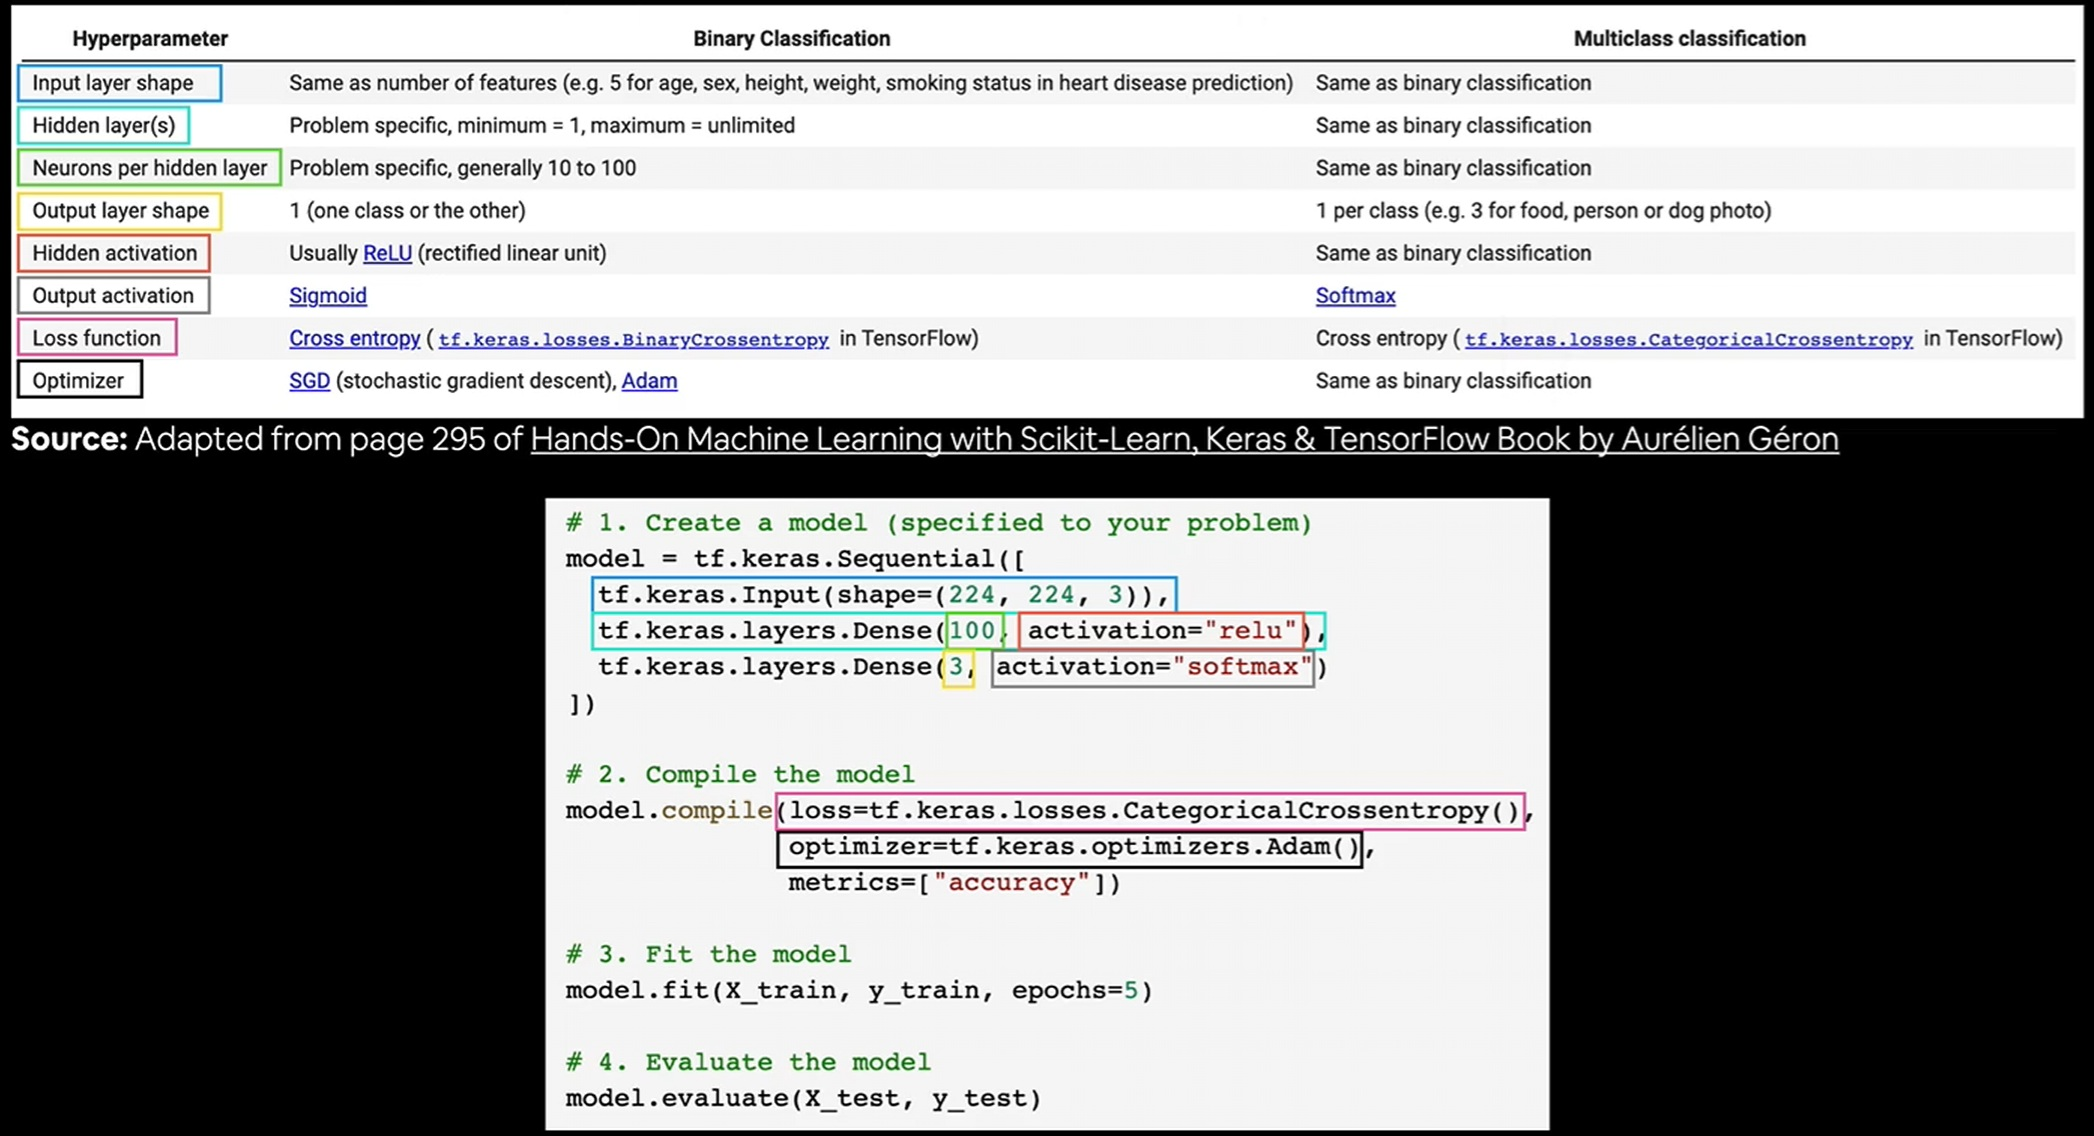

## Creating data to view and fit

### Creating sample circle data

In [1]:
from sklearn.datasets import make_circles

# Make 1000 examples
n = 1000

# Create circles
X, y = make_circles(n_samples=n, noise=0.05, random_state=42)

In [2]:
# Check out the features
print(X[:5])

[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]


In [3]:
# Check out the labels
print(y[:5])

[1 1 1 1 0]


### Visualize our circle data

Our data is a littlt bit hard to understand, let's visualize it!

In [4]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


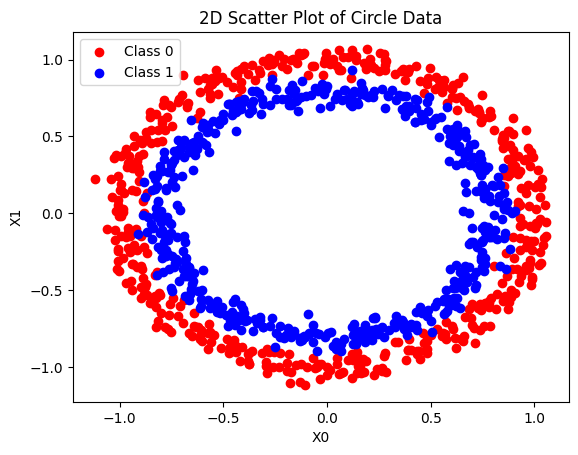

"\nThe data is not linearly separable, meaning we can't draw a straight line to separate the two classes.\nThis is where neural networks come in handy.\n\nLabel 0: Points that are inside the inner circle.\nLabel 1: Points that are outside the inner circle but within the outer circle.\n"

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(circles[circles['label'] == 0]['X0'], circles[circles['label'] == 0]['X1'], color='red', label='Class 0')
plt.scatter(circles[circles['label'] == 1]['X0'], circles[circles['label'] == 1]['X1'], color='blue', label='Class 1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.title('2D Scatter Plot of Circle Data')
plt.show()

# * Note: 
"""
The data is not linearly separable, meaning we can't draw a straight line to separate the two classes.
This is where neural networks come in handy.

Label 0: Points that are inside the inner circle.
Label 1: Points that are outside the inner circle but within the outer circle.
"""


In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# How many samples we're working with
len(X), len(y)

(1000, 1000)

In [8]:
# View the first example of features and labels
X[0], y[0]

(array([0.74220688, 0.24668576]), 1)

## Build our classification models

In [9]:
import tensorflow as tf

2024-11-09 09:14:42.260211: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 09:14:47.708757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 09:14:49.544181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 09:14:50.030572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 09:14:53.767725: I tensorflow/core/platform/cpu_feature_guar

In [10]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=10)

I0000 00:00:1731114943.700678    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.


Epoch 1/10


I0000 00:00:1731114948.519897    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731114948.519951    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731114948.532768    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731114948.532817    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731114948.532834    2124 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:08 4s/step - accuracy: 0.3750 - loss: 4.2113

I0000 00:00:1731114953.328326    4168 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4883 - loss: 2.6029
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5358 - loss: 0.6995 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5219 - loss: 0.6937 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5076 - loss: 0.6935 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5043 - loss: 0.6938 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4844 - loss: 0.6942 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4720 - loss: 0.6944 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4419 - loss: 0.6946 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4335 - loss: 0.6947 
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4322 - loss: 0.6947 


In [11]:
model_1.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4683 - loss: 0.6928


[0.6932806372642517, 0.46399998664855957]

## Improving our model

Looking at the accuracy metric, our model performs poorly (50% accuracy on a binary classification problem is the equivalent of guessing), but what if we trained it for longer?

In [12]:
# Try to improve our model by training for longer
model_1.fit(X, y, epochs=200, verbose=0)

In [13]:
model_1.evaluate(X, y)

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4062 - loss: 0.6956

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4875 - loss: 0.6928


[0.693287193775177, 0.4729999899864197]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [14]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API but with an extra layer
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1), # add another layer
    tf.keras.layers.Dense(1),
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0)


# Evaluate the model
model_2.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5045 - loss: 7.8989


[7.971191883087158, 0.5]

Still not even as good as guessing (~50% accuracy)

Let's remind ourselves of a couple more ways we can use to improve our models.

### Adding layers and increase the number of hidden units

In [15]:
# Set the random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API but with an extra layer
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(100), # add 100 dense neurons
    tf.keras.layers.Dense(10), # add another layer with 10 neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_3.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5146 - loss: 0.6917


[0.6952929496765137, 0.49300000071525574]

Performance is still really poor.

Let's make some visualizations to see what's happening.

Note: When model is performing strangely or there's something going on with the data we are not quite sure of, remember to **visualize visualize visualize**. Inspect your data, inspect your model, inspect your model's predictions.

### Visualize the model's predictions

We are going to create a function plot_decision_boundary() which:
- Takes in a trained model, features(`X`) and labels(`y`).
- Create a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
- Makes predictions across the meshgrid.
- Plots the predictions as well as a line between the fifferent zones (where each unique class falls).

In [16]:
import numpy as np

def plot_decision_boundary(model, X, y):
    """
    Plots the decision boundary created by a model predicting on X.
    This function has been adapted from two phenomenal resources:
    1. CS231n - https://cs231n.github.io/neural-networks-case-study/
    2. Made with ML basics - https://github.com/GokuMohandas/Made-With-ML
    """

    # Define the axis boundaries of the plot and create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    # Create X values (we're going to predict on all of these)
    x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

    # Make predictions using the trained model
    y_pred = model.predict(x_in)

    # Check for multi-class
    if model.output_shape[-1] > 1: # if there's more than 1 output, we'll assume it's multi-class
        print("doing multiclass classification...")
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape) 
    else:
        print("doing binary classification...")
        y_pred = np.round(y_pred).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
doing binary classification...


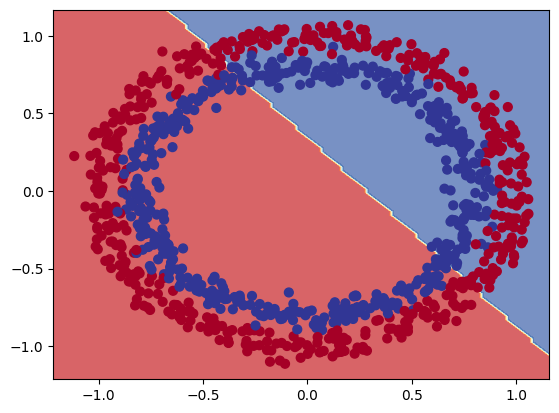

In [17]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

### Testing our model in regression problem

In [18]:
# Create some regression data
X_regression = tf.range(0, 1000, 5)
y_regression = tf.range(100, 1100, 5)

# Split our regression data into training and test sets
split_size = int(0.8 * len(X_regression)) # 80% train, 20% test
X_reg_train, y_reg_train = X_regression[:split_size], y_regression[:split_size]
X_reg_test, y_reg_test = X_regression[split_size:], y_regression[split_size:]

# Check the lengths
len(X_reg_train), len(X_reg_test), len(y_reg_train), len(y_reg_test)

(160, 40, 160, 40)

In [19]:
# Recreate the model for regression problem

# Set random seed
tf.random.set_seed(42)

# 1. Create the model with same architecture as model_3
model_reg = tf.keras.Sequential([
    tf.keras.layers.Dense(100), # add 100 dense neurons
    tf.keras.layers.Dense(10), # add another layer with 10 neurons
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_reg.compile(loss=tf.keras.losses.mae, # change the loss function to mean absolute error
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) # change the metrics to mean absolute error

# 3. Fit the model
model_reg.fit(tf.expand_dims(X_reg_train, axis=1), y_reg_train, epochs=100, verbose=0)

# Evaluate the model
model_reg.evaluate(X_regression, y_regression)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 49.6268 - mae: 49.6268


[40.658687591552734, 40.658687591552734]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


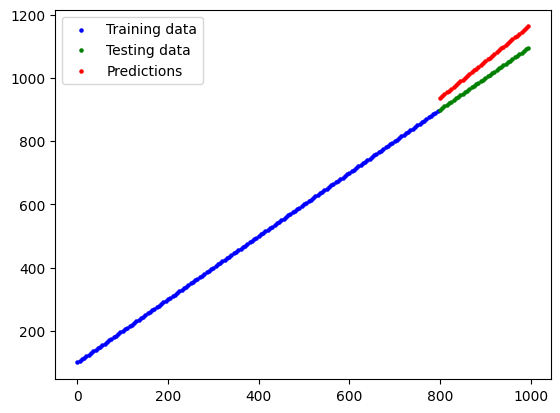

In [20]:
# Make predictions with the regression model
y_reg_preds = model_reg.predict(tf.expand_dims(X_reg_test, axis=1))

# Plot the model's predictions against the regression data
plt.scatter(X_reg_train, y_reg_train, color='b', label='Training data', s=5)
plt.scatter(X_reg_test, y_reg_test, color='g', label='Testing data', s=5)
plt.scatter(X_reg_test, y_reg_preds, color='r', label='Predictions', s=5)
plt.legend()

# The predictions looks better than complete guessing, so this means our model must be learning something.
# There must be something we are missing our on for our classification model.

### The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)

In [21]:
# Let's recreate the basic setting in TensorFlow Playground
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_4.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_4.evaluate(X, y)

# Our model performs like guessing in the basic setting.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4955 - loss: 1.0958


[1.0698974132537842, 0.5]

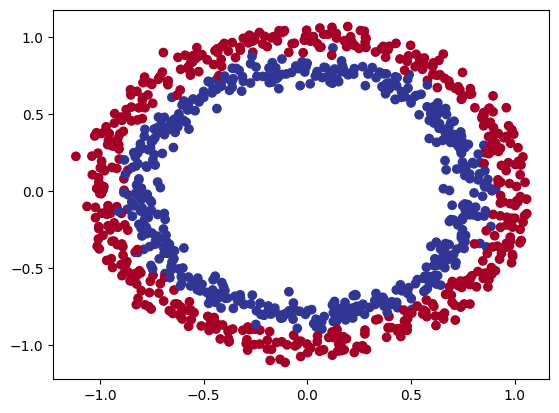

In [22]:
# Check out our data again
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classification...


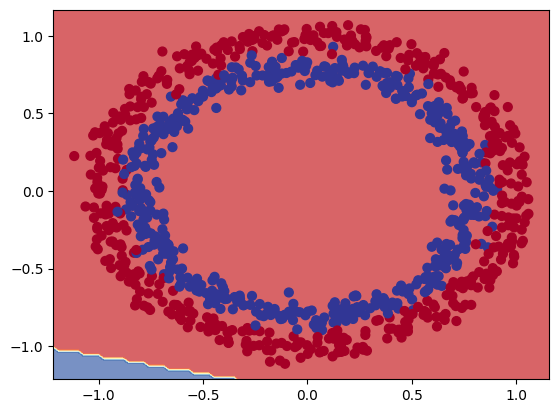

In [23]:
# And let's see how our model is making predictions on it.
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

### Trying `ReLU` activation for non-linear data

ReLU: Rectified Linear Unit

In [24]:
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # change the activation function to ReLU
    tf.keras.layers.Dense(1) 
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_5.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_5.evaluate(X, y)

# Still worse than guessing, let try to add more layers

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4856 - loss: 1.0796


[1.1306124925613403, 0.4659999907016754]

In [25]:
# Add more layers for our ReLU model
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # add more neurons and layers
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1) 
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_6.fit(X, y, epochs=100, verbose=0)

# Evaluate the model
model_6.evaluate(X, y)

# Much better! Our model is learning something now.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8179 - loss: 0.5003


[0.49206289649009705, 0.8420000076293945]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
doing binary classification...


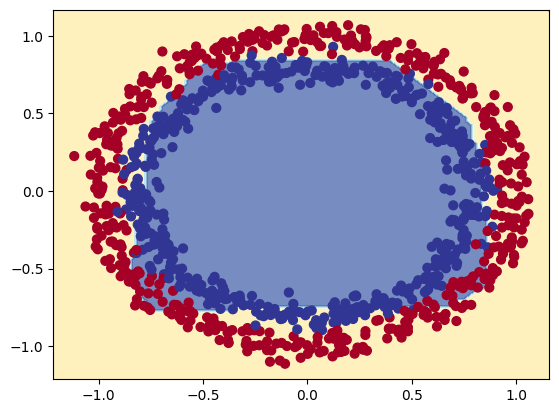

In [26]:
# Checkout the decision boundary
plot_decision_boundary(model_6, X, y)

# Looks like we still have room for improvement

### Adding Sigmoid activation output layer and longer training

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [27]:
# Set random seed
tf.random.set_seed(42)

# Create the model with ReLU activation and sigmoid output
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # change the output activation to sigmoid
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Fit the model
model_7.fit(X, y, epochs=200, verbose=0) # train for longer

# Evaluate the model
model_7.evaluate(X, y)

# It reach over 95% accuracy, which is pretty good.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - loss: 0.3640


[0.36492645740509033, 0.8529999852180481]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classification...


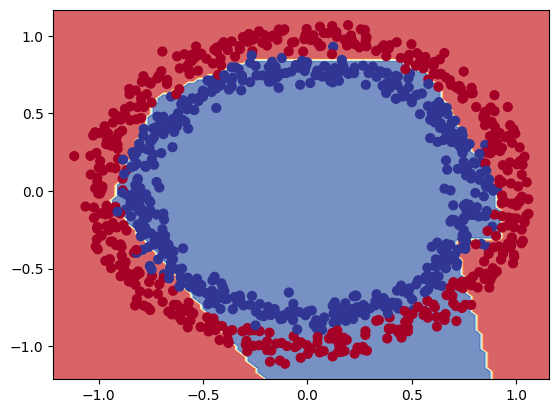

In [28]:
# Checkout the decision boundary
plot_decision_boundary(model_7, X, y)

Nice! It looks like our model is almost perfectly (apart from a few examples) separating the two circles.

> 🤔 **Question:** What's wrong with the predictions we've made? Are we really evaluating our model correctly here? Hint: what data did the model learn on and what did we predict on?

Before we answer that, it's important to recognize what we've just covered.

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

We've been using a linear function or a non-linear function the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

## Experimenting Linear and Non-Linear with toy tensors

In [29]:
# Create a toy tensor (similar to the data we have been working with)
toy_tensor = tf.cast(tf.range(-10, 10), tf.float32)
toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

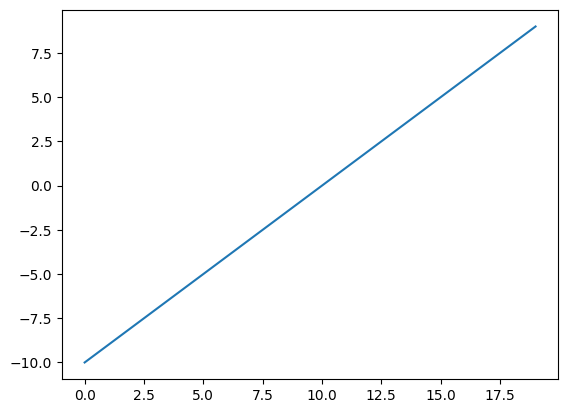

In [30]:
# Visualize the toy tensor
plt.plot(toy_tensor)

A straight (linear) line!

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

In [31]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

sigmoid_toy_tensor = sigmoid(toy_tensor)
sigmoid_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397868e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726230e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105854e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

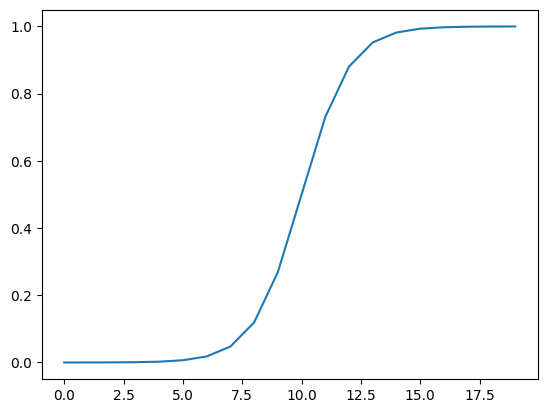

In [32]:
# Plot the toy tensor transformed by the sigmoid function
plt.plot(sigmoid_toy_tensor)

A non-straight (non-linear) line!

Okay, how about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

In [33]:
def relu(x):
    return tf.maximum(0, x)

relu_toy_tensor = relu(toy_tensor)
relu_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

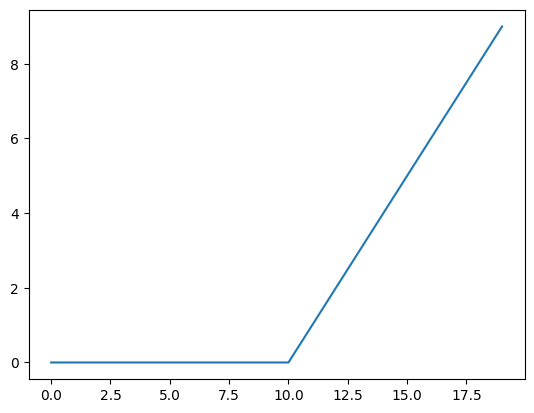

In [34]:
# Plot the toy tensor transformed by the ReLU function
plt.plot(relu_toy_tensor)

Another non-straight line!

Well, how about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)?

In [35]:
linear_toy_tensor = tf.keras.activations.linear(toy_tensor)
linear_toy_tensor

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

In [36]:
# The linear activation function doesn't change the input tensor
toy_tensor == linear_toy_tensor

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Where as, with our non-linear functions, our data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.

> 📖  **Resource:** For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

## Evaluating and improving our classification model

If you answered the question above, you might've picked up what we've been doing wrong.

We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

Let's do it.

In [37]:
# What's the size of the dataset?
len(X)

1000

In [38]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [42]:
# Recreate a model to fit on the training data and evaluate on the testing data

# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # changed the learning rate from 0.001 to 0.01
                metrics=['accuracy'])

# Fit the model
model_8_fit_history = model_8.fit(X_train, y_train, epochs=25) # testing with only 25 steps for our new model

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5376 - loss: 0.6928 
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5828 - loss: 0.6765
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5471 - loss: 0.6676
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6318 - loss: 0.6540
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6615 - loss: 0.6341
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6952 - loss: 0.6076
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7175 - loss: 0.5774
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7493 - loss: 0.5465
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7791 - loss: 0.5174
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8146 - loss: 0.4921
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8217 - loss: 0.4697 
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8378 - 

In [43]:
# Evaluate the model
model_7.evaluate(X, y)

# The performance was great (over 90% accuracy) for only 25 epochs

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8500 - loss: 0.3640


[0.36492645740509033, 0.8529999852180481]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
doing binary classification...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classification...


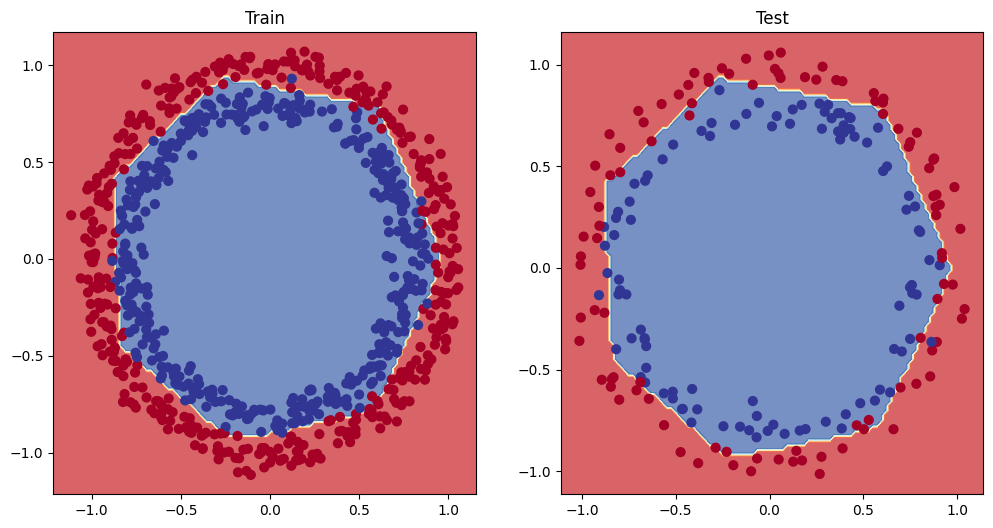

In [44]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # 1 row, 2 columns with 1st value is training plot
plt.title('Train')
plot_decision_boundary(model_8, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_8, X=X_test, y=y_test)

plt.show()

### Using the TensorFlow History object to plot a model's loss curves

How did the performance change everytime the model had a chance to look at the data (once every epoch)?

We can check the **loss curves** (also referred to as the **learning curves**) from variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

In [ ]:
# see this fit history by transfering it to a DataFrame
pd.DataFrame(model_8_fit_history.history)

,accuracy,loss
0,0.54250,0.686216
1,0.58250,0.673631
2,0.56625,0.662945
3,0.64500,0.647412
4,0.69250,0.626755
5,0.71875,0.600043
6,0.73500,0.570398
7,0.76250,0.541239
8,0.78000,0.515635
9,0.80125,0.493717


Text(0.5, 1.0, 'Model 8 loss curves')

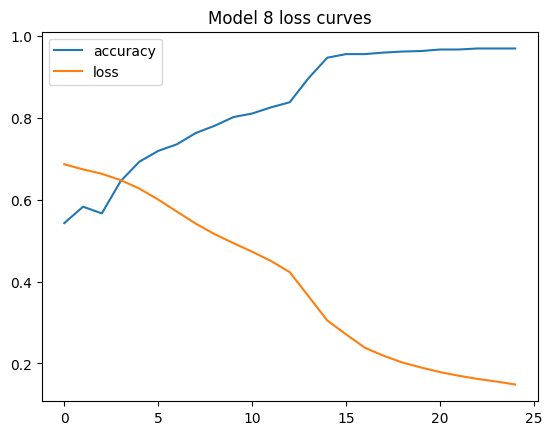

In [46]:
# Plot the los curves
pd.DataFrame(model_8_fit_history.history).plot()
plt.title('Model 8 loss curves')

🔑 Note: For many problems, the loss function going down means the moddel is improving (the predictions it's making are getting closer to the ground truth labels).